In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle

In [ ]:
# link to download: https://www.kaggle.com/grouplens/movielens-20m-dataset
#Load movies data
path = 'Downloads/movielens-20m-dataset/'
movies = pd.read_csv(path + 'movie.csv')
#genome_scores = pd.read_csv(path + 'genome_scores.csv')
tags = pd.read_csv(path + 'tag.csv')
#genome_tags = pd.read_csv(path + 'genome_tags.csv')
#Use ratings data to downsample tags data to only movies with ratings 
ratings = pd.read_csv(path + 'rating.csv')
#ratings = ratings.drop_duplicates('movieId')

In [ ]:
movies.tail()
movies['genres'] = movies['genres'].str.replace('|',' ')

In [ ]:
len(movies.movieId.unique())

27278

In [ ]:
len(ratings.movieId.unique())

26744

In [ ]:
#limit ratings to user ratings that have rated more that 55 movies -- 
#Otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

# list the movie titles that survive the filtering
movie_list_rating = ratings_f.movieId.unique().tolist()

In [ ]:
# no worries: we have kept 97% of the original movie titles in ratings data frame
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

97.85908057775497

In [ ]:
# but only 57% of the users 
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

57.797867040211415

In [ ]:
#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [ ]:
movies.head(3)

movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure Animation Children Comedy Fantasy  
1                   Adventure Children Fantasy  
2                               Comedy Romance

In [ ]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [ ]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

In [ ]:
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure Animation Children Comedy Fantasy   
1        1  Toy Story (1995)  Adventure Animation Children Comedy Fantasy   
2        1  Toy Story (1995)  Adventure Animation Children Comedy Fantasy   

   userId                      tag  
0  1644.0                  Watched  
1  1741.0       computer animation  
2  1741.0  Disney animated feature

In [ ]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                            metadata  
0  Watched computer animation Disney animated fea...  
1  time travel adapted from:book board game child...  
2  old people that is actually funny sequel fever...

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(26694, 23704)


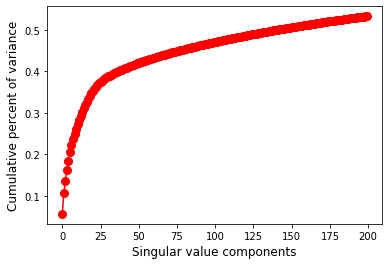

In [ ]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [ ]:
#number of latent dimensions to keep
n = 200 
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [ ]:
# our content latent matrix:
latent_matrix.shape

(26694, 200)

In [ ]:
ratings_f.head()

userId  movieId  rating
0       1        2     3.5
1       1       29     3.5
2       1       32     3.5
3       1       47     3.5
4       1       50     3.5

In [ ]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")

In [ ]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [ ]:
ratings_f2.head(3)

userId   1       2       3       5       7       8       11      13      \
movieId                                                                   
1           0.0     0.0     4.0     0.0     0.0     4.0     4.5     4.0   
2           3.5     0.0     0.0     3.0     0.0     0.0     0.0     3.0   
3           0.0     4.0     0.0     0.0     3.0     5.0     0.0     0.0   

userId   14      16      ...  138474  138475  138477  138483  138484  138486  \
movieId                  ...                                                   
1           4.5     3.0  ...     5.0     0.0     3.0     4.0     0.0     5.0   
2           0.0     0.0  ...     4.0     0.0     0.0     3.0     3.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     4.0     0.0   

userId   138487  138490  138492  138493  
movieId                                  
1           0.0     0.0     0.0     3.5  
2           0.0     0.0     0.0     4.0  
3           0.0     0.0     0.0     0.0  

[3 rows x 80046 columns]

In [ ]:
len(ratings_f.movieId.unique())

26694

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2,
                             index=Final.title.tolist())

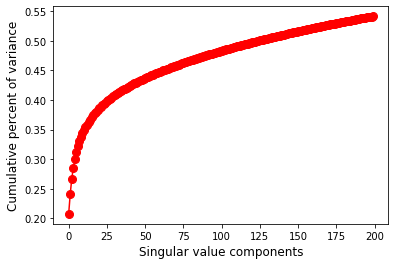

In [ ]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

content  collaborative    hybrid
Toy Story 2 (1999)          0.963319       0.750948  0.857133
Bug's Life, A (1998)        0.911105       0.646937  0.779021
Ratatouille (2007)          0.905437       0.426630  0.666034
Monsters, Inc. (2001)       0.891255       0.622280  0.756768
Finding Nemo (2003)         0.880705       0.597363  0.739034
Ice Age (2002)              0.880325       0.482755  0.681540
Toy Story 3 (2010)          0.869905       0.405202  0.637553
Incredibles, The (2004)     0.799849       0.564249  0.682049
Monsters University (2013)  0.788256       0.207868  0.498062
Up (2009)                   0.758966       0.378012  0.568489
Antz (1998)                 0.751689       0.557802  0.654745